### Predict blood donations

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pystan_utils
from sklearn import preprocessing  ## for standardization 
from sklearn.utils import resample ## 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

Blood transfusion saves lives - from replacing lost blood during major surgery or a serious injury to treating various illnesses and blood disorders. Ensuring that there's enough blood in supply whenever needed is a serious challenge for the health professionals. According to WebMD, "about 5 million Americans need a blood transfusion every year".

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive. We want to predict whether or not a donor will give blood the next time the vehicle comes to campus.

### Data Preparation

In [5]:
# Read in dataset
transfusion = pd.read_csv('transfusion.data')

# No. of rows and columns
print(transfusion.shape)
# Print out the first rows of our dataset
transfusion.head()

(748, 5)


,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [9]:
# Change columns name:
newColName=["Recency","Frequency","Monetary","Time","Class"]
transfusion.set_axis(newColName,axis=1,inplace=True)
# Missing values 
print(transfusion.isnull().sum())
transfusion.head()

Recency      0
Frequency    0
Monetary     0
Time         0
Class        0
dtype: int64


,Recency,Frequency,Monetary,Time,Class
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


RFM stands for Recency, Frequency and Monetary Value and it is commonly used in marketing for identifying your best customers. In our case, our customers are blood donors.

RFMTC is a variation of the RFM model. Below is a description of what each column means in our dataset:

- **Recency:** months since the last donation
- **Frequency:** total number of donation
- **Monetary:** total blood donated in c.c.
- **Time:** months since the first donation
- **Class:** a binary variable representing whether he/she donated blood in March 2007 (1 stands for donating blood; 0 stands for not donating blood

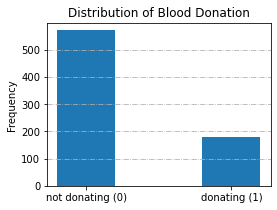

In [153]:
no_class = transfusion.Class.value_counts().sort_index().values.tolist()
label = ["not donating (0)","donating (1)"]
def plot_bar_x():
    plt.figure(figsize=(4,3))
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, no_class,width=.4)
    #plt.xlabel('Travel mode')
    plt.ylabel('Frequency')
    plt.xticks(index, label, rotation=0)
    plt.grid(linestyle="-.",axis="y")
    plt.title('Distribution of Blood Donation')
    plt.show()

plot_bar_x()

In [11]:
# Print a concise summary of transfusion DataFrame
print(transfusion.dtypes)
transfusion.describe()

Recency      int64
Frequency    int64
Monetary     int64
Time         int64
Class        int64
dtype: object


,Recency,Frequency,Monetary,Time,Class
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


Let's now preprocess the data by:
- Separating the inputs ($X$) from the target ($y$)
- Standardizing the input variables in order to have zero mean and unit standard deviation
- Split data into train and test sets

In [115]:
# Separate between features/inputs (X) and target/output variables (y)
X = transfusion.drop("Class",axis=1)

In [116]:
# Get column names first
names = X.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=names)
scaled_X.head()

,Recency,Frequency,Monetary,Time
0,-0.927899,7.623346,7.623346,2.615633
1,-1.175118,1.282738,1.282738,-0.257881
2,-1.051508,1.796842,1.796842,0.029471
3,-0.927899,2.482313,2.482313,0.439973
4,-1.051508,3.167784,3.167784,1.753579


In [117]:
# X and y as matrix
X = scaled_X.values
y = transfusion["Class"].astype("int").values

In [118]:
# Split data into train and test sets
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("No. of train data: %d" % len(y_train))
print("No. of test data: %d" % len(y_test))

No. of train data: 493
No. of test data: 255


### Oversample minority class
Always split into test and train sets BEFORE trying oversampling techniques!

In [123]:
# concatenate our training data back together
X_train = pd.DataFrame(X_train, columns=names)
y_train = pd.DataFrame(y_train,columns=["Class"])
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_donating = X[X.Class==0]
donating = X[X.Class==1]

# upsample minority
donating_upsampled = resample(donating,
                          replace=True, # sample with replacement
                          n_samples=len(not_donating), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_donating, donating_upsampled])

# check new class counts
upsampled.Class.value_counts()

1    385
0    385
Name: Class, dtype: int64

In [128]:
# New X_train and y_train
X_train = upsampled.drop("Class",axis=1).values
y_train = upsampled["Class"].values

### Plate notation

![title](PGM_LOG.png)

### Stan model : Binary logistic regression model

Ok, time to do it in STAN!

Since we don't have a column in the inputs ($X$) that is always equal to 1, we need to incorporate the bias term in our model explicitly. Hence, we shall include an extra bias parameter $\alpha$ in the model. The likelihood is then of the form:

$ y_n \sim \mbox{Bernouli}(\mbox{Sigmoid}(\alpha + \textbf{B} \textbf{x}_n^T)) $

where $\textbf{B} = (\beta_1,\dots,\beta_D)^T$

$D$ : Number of features

STAN expects the targets $y_n$ as integers in {0,1}!



In [154]:
STAN_binary_logistic = """
data {
    int<lower=1> N;                              // number of data items
    int<lower=1> D;                              // number of features/predictors
    int<lower=0,upper=1> y[N];                   // target vector
    matrix[N,D] X;                               // predictor matrix
}
parameters {
    real alpha;                                  // intercept
    vector[D] beta;                              // coefficients for predictors
}
model {
    alpha ~ normal(0,1);                         // prior on the intercept
    beta ~ normal(0,1);                          // prior on the coefficients
    y ~ bernoulli_logit(alpha + X * beta);       // likelihood
}
"""
# compile model
sm = pystan.StanModel(model_code = STAN_binary_probit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3502716902400b92698fc0af13ed9572 NOW.


In [155]:
# prepare data for Stan model
N, D = X_train.shape
print("N=%d, D=%d" % (N,D))
data = {'N': N, 'D': D, 'X': X_train, 'y': y_train}

N=770, D=4


In [156]:
%%time
# run inference
iterations = 5000
no_chains = 4
fit = sm.sampling(data=data, algorithm="NUTS", seed=0, chains=no_chains, iter= iterations, control={'max_treedepth': 50})

# show results
print(fit)

Inference for Stan model: anon_model_3502716902400b92698fc0af13ed9572.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    -0.11  5.8e-4   0.05  -0.21  -0.15  -0.11  -0.08  -0.02   7250    1.0
beta[1]  -0.45  7.9e-4   0.07  -0.58   -0.5  -0.45  -0.41  -0.32   6964    1.0
beta[2]   0.22    0.01   0.72   -1.2  -0.26   0.23    0.7   1.62   4470    1.0
beta[3]   0.22    0.01   0.71  -1.18  -0.26    0.2    0.7   1.64   4494    1.0
beta[4]  -0.25  8.6e-4   0.07  -0.39   -0.3  -0.25   -0.2  -0.11   7106    1.0
lp__    -468.0    0.03   1.59 -471.8 -468.8 -467.7 -466.8 -465.9   3861    1.0

Samples were drawn using NUTS at Wed Apr 15 12:50:51 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Wall time: 1min


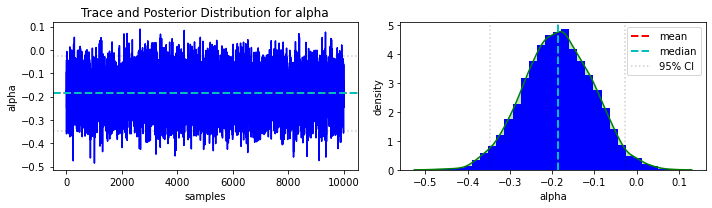

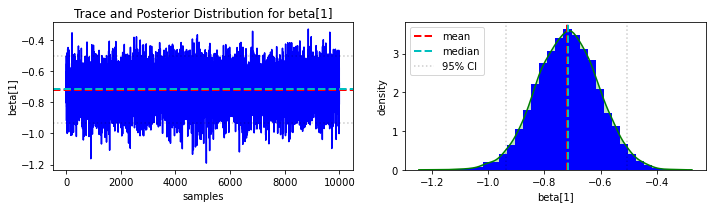

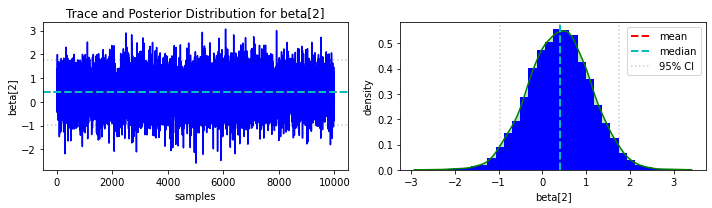

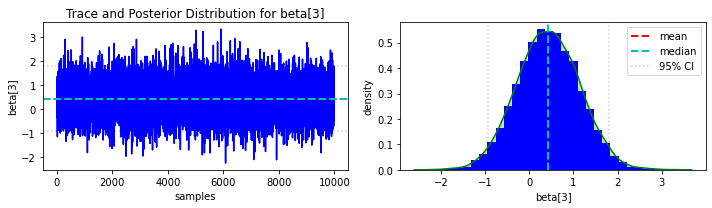

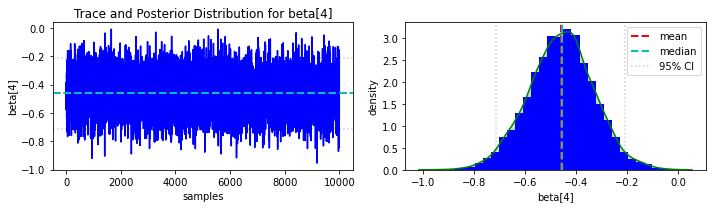

In [142]:
plt.rcParams["figure.figsize"]=(10,3)
pystan_utils.plot_trace(fit["alpha"],"alpha")
plt.show()
for d in range(1,D+1):
    pystan_utils.plot_trace(fit["beta[%d]"%d],"beta[%d]"%d)
    plt.show()    

predictions: [0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1
 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0
 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0
 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1
 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0]
true values: [0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1
 0 0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1
 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0

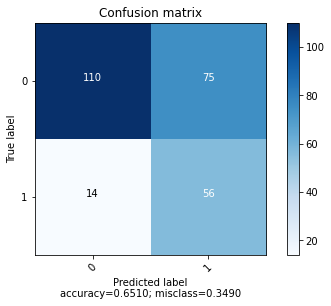

In [157]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays
# make predictions for test set
mu = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)
y_hat = (mu > 0).astype("int")
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
# print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))
pystan_utils.plot_confusion_matrix(confusion_matrix(y_test, y_hat),normalize= False, target_names=[0,1])

### Stan model : Binary probit regression model

Probit regression is very similar to logistic regression but uses a different link function: 
- probit instead of the logistic sigmoid

In [160]:
STAN_binary_probit = """
data {
    int<lower=1> N;                              // number of data items
    int<lower=1> D;                              // number of features/predictors
    int<lower=0,upper=1> y[N];                   // target vector
    matrix[N,D] X;                               // predictor matrix
}
parameters {
    real alpha;                                  // intercept
    vector[D] beta;                              // coefficients for predictors
}
model {
    alpha ~ normal(0,1);                         // prior on the intercept
    beta ~ normal(0,1);                          // prior on the coefficients
    y ~ bernoulli(Phi_approx(alpha + X * beta)); // likelihood       
}
"""
# compile model
sm = pystan.StanModel(model_code = STAN_binary_probit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0db8f75fa39b1ede2450722a08a3b202 NOW.


In [161]:
%%time
# run inference
iterations = 5000
no_chains = 4
fit = sm.sampling(data=data, algorithm="NUTS", seed=0, chains=no_chains, iter= iterations, control={'max_treedepth': 50})

# show results
print(fit)

Inference for Stan model: anon_model_0db8f75fa39b1ede2450722a08a3b202.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    -0.11  5.8e-4   0.05  -0.21  -0.15  -0.11  -0.08  -0.02   7250    1.0
beta[1]  -0.45  7.9e-4   0.07  -0.58   -0.5  -0.45  -0.41  -0.32   6964    1.0
beta[2]   0.22    0.01   0.72   -1.2  -0.26   0.23    0.7   1.62   4470    1.0
beta[3]   0.22    0.01   0.71  -1.18  -0.26    0.2    0.7   1.64   4494    1.0
beta[4]  -0.25  8.6e-4   0.07  -0.39   -0.3  -0.25   -0.2  -0.11   7106    1.0
lp__    -468.0    0.03   1.59 -471.8 -468.8 -467.7 -466.8 -465.9   3861    1.0

Samples were drawn using NUTS at Wed Apr 15 12:56:18 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Wall time: 56.3 s


predictions: [0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1
 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0
 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0
 0 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1
 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0]
true values: [0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1
 0 0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1
 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0

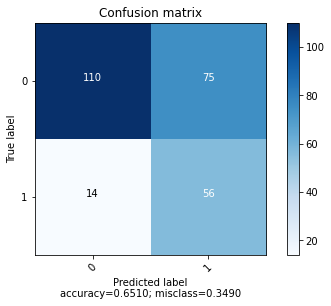

In [162]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays
# make predictions for test set
mu = np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)
y_hat = (mu > 0).astype("int")
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
# print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))
pystan_utils.plot_confusion_matrix(confusion_matrix(y_test, y_hat),normalize= False, target_names=[0,1])

### Non-Bayesian inference 

predictions: [0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1
 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0
 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 0
 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1
 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0]
true values: [0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1
 0 0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1
 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0

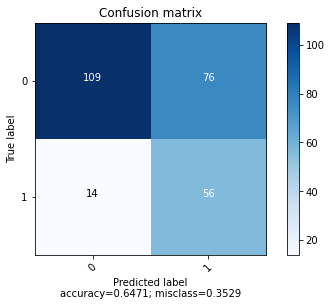

In [152]:
# create and fit logistic regression model
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
# print("Accuracy:", np.sum(y_hat == y_test) / len(y_test))
pystan_utils.plot_confusion_matrix(confusion_matrix(y_test, y_hat),normalize= False, target_names=[0,1])